---
# Setup

In [ ]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

In [ ]:
device

device(type='cuda')

## Download Data

In [ ]:
load_input = np.load('/content/Input_sub-210861_ses-20130701_behavior+ecephys+ogen.npy', allow_pickle=True)
load_output = np.load('/content/Output_sub-210861_ses-20130701_behavior+ecephys+ogen.npy', allow_pickle=True)
print(load_input.shape)
print(load_output.shape)

(20, 407, 1079)
(9, 407, 335)


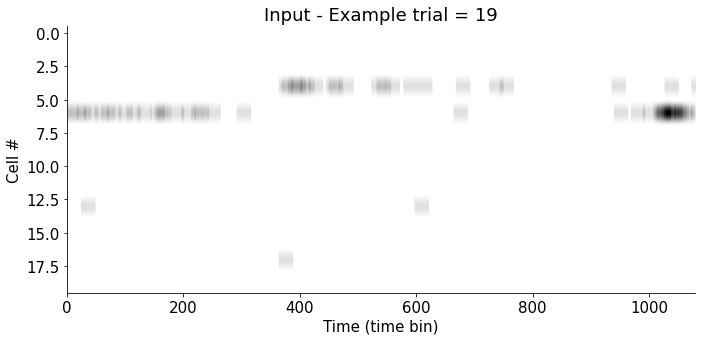

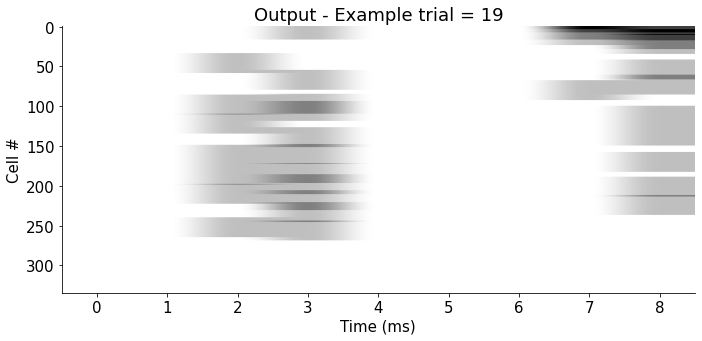

In [ ]:
#plot input and output data
trial_selected = 19
plt.figure(figsize = (10, 5))
plt.imshow(load_input[:, trial_selected , :], cmap='gray_r', aspect='auto')
plt.xlabel('Time (time bin)')
plt.ylabel('Cell #')
plt.title(f"Input - Example trial = {trial_selected}")
plt.show()

plt.figure(figsize = (10, 5))
plt.imshow(load_output[:, trial_selected , :].T, cmap='gray_r', aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f"Output - Example trial = {trial_selected}")
plt.show()


In [ ]:
# permute dimension of the data
load_input2 = np.transpose(load_input, (2,1,0))
load_output2 = np.transpose(load_output, (2,1,0))
print(load_input2.shape)
print(load_output2.shape)

(1079, 407, 20)
(335, 407, 9)


In [ ]:
# downsampling
new_input_data = np.zeros((load_output2.shape[0], load_input2.shape[1], load_input2.shape[2]))
stride = int(load_input2.shape[0] / load_output2.shape[0])

for i in range(load_output2.shape[0]):
    d = np.array(load_input2[i*stride:i*stride+stride,:,:]).mean(axis=0)
    new_input_data[i,:,:] = d

print(new_input_data.shape)

(335, 407, 20)


In [ ]:
input_data = torch.from_numpy(new_input_data).to(device).float() #turn format from np to torch tensr / input #torch.Size([250 time bin, 100 trials, 300 neurons])
output_data = torch.from_numpy(load_output2).to(device).float() #output

print(input_data.shape)
print(output_data.shape)
## data (time bin, trial, total data(in+out))

torch.Size([335, 407, 20])
torch.Size([335, 407, 9])


In [ ]:
# number of trials for training set
ntrials = 300

train_input = input_data[:, :ntrials,:]
train_output = output_data[:, :ntrials,:]

test_input = input_data[:, ntrials:,:]
test_output = output_data[:, ntrials:,:]

#shape = ( time bin, trials , neurons)

NN1 = train_input.shape[-1] #input number
NN2 = train_output.shape[-1] #output number

In [ ]:
# set the seed
#np.random.seed(42)

# total simulate neurons(input+output)
NN = NN1+NN2

# number of hidden layer feature
#n_hidden = 10 

---
#  Define RNN / LSTM

In [ ]:
class Net(nn.Module): #create Net which has similar structure with nn.Module
  def __init__(self, n_hidden, NN1, NN2, bidi=True): #self = Net
    super(Net, self).__init__() #assign Net to itself

    # define RNN structure
    # from input to hidden layer
    self.rnn = nn.RNN(NN1, n_hidden, num_layers = 10, dropout = 0.5)

    #self.rnn = nn.LSTM(NN1, n_hidden, num_layers = 1, dropout = 0.5)

    #self.rnn = nn.GRU(NN1, n_hidden, num_layers = 1, dropout = 0)
    
    #from hidden layer to output 
    self.fc = nn.Linear(n_hidden, NN2)  #fully connected

#start doing forward
  def forward(self, x): # x is the input for nn.RNN / correspond to train_input in the following code
    #the format of x should satisfy the format of nn.RNN in nn.Module: (sequence length, batch size, input size)

    y = self.rnn(x)[0]
    #0th element of output tensor: ( sequence length, N(batch_size),D(=2 if bidirectional)∗H(hidden size) )

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :n_hidden] + y[:, :, n_hidden:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q
    #z is the model output , q is the thing before activation fn

In [ ]:
net.rnn(train_input)[0].shape

torch.Size([250, 100, 20])

In [ ]:
net.rnn

RNN(300, 10, bidirectional=True)

---
# Train the RNN

In [ ]:
# we initialize the neural network
n_hidden = 10 #hidden neuron
net = Net(n_hidden, NN1, NN2, bidi = False).to(device) #initilization of the model parameters
# hidden feature number


# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = train_input.mean((0,1)) #set the final layer = mean of input data

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)

In [ ]:
%time
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000 #number of iteration
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(train_input)  #z: predictive output series, y:latent layer

  # our log-likelihood cost
  cost = Poisson_loss(z, train_output).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 200 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
iteration 0, cost 0.0170
iteration 200, cost 0.0166
iteration 400, cost 0.0166
iteration 600, cost 0.0165
iteration 800, cost 0.0165


## Traning set

In [ ]:
hidden_layer_num = 10

In [ ]:
train_predict, train_y = net(train_input) 

#change to numpy array
train_predict_np = train_predict.detach().cpu().numpy()
train_output_np = train_output.detach().cpu().numpy()
    

#calculate mean firing rate across trials
train_pred_mean = []
for i in range(9):
    mean = train_predict_np[:,:,i].mean(axis=1)
    train_pred_mean.append(mean)

train_true_mean = []
for i in range(9):
    mean = train_output_np [:,:,i].mean(axis=1)
    train_true_mean.append(mean)

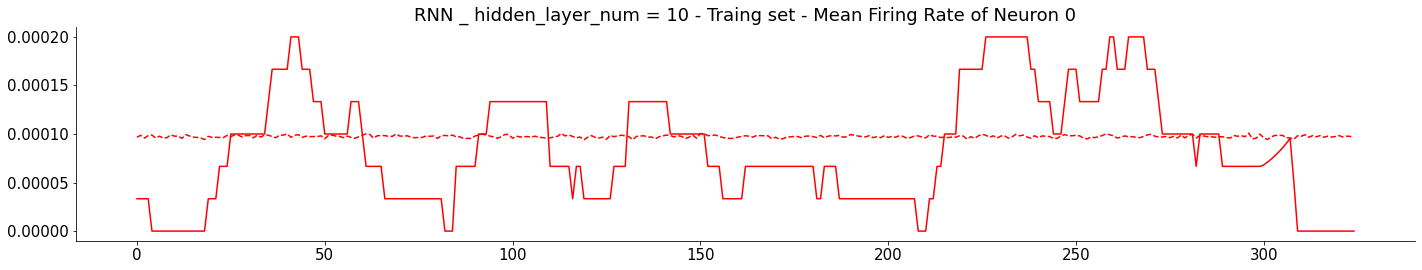

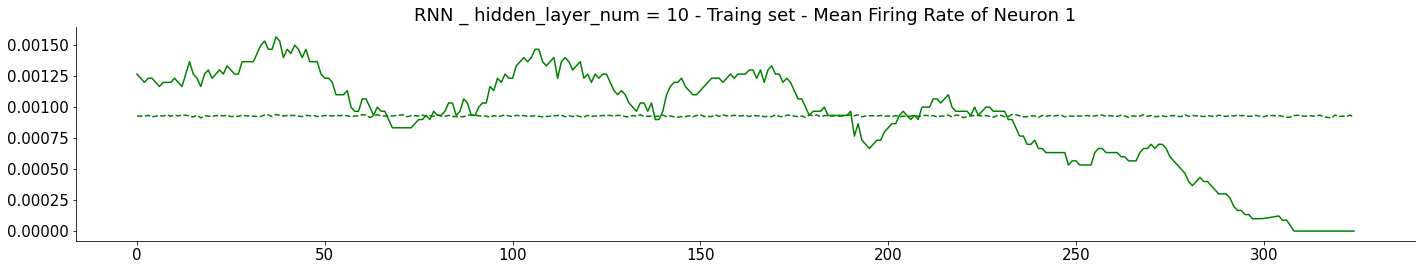

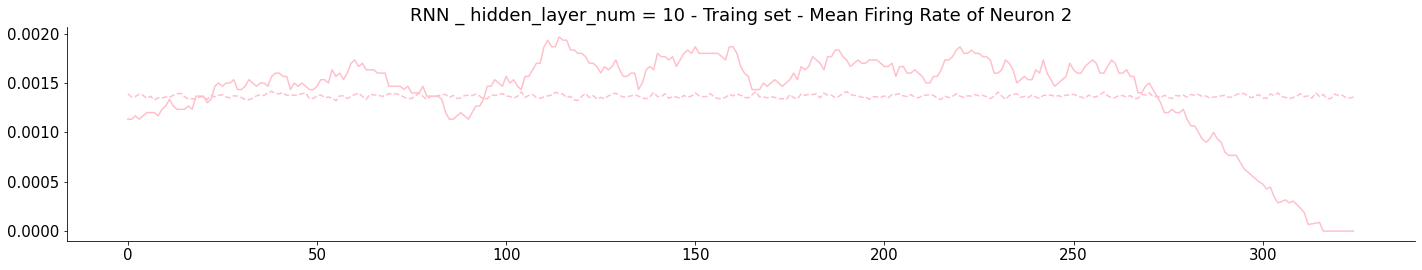

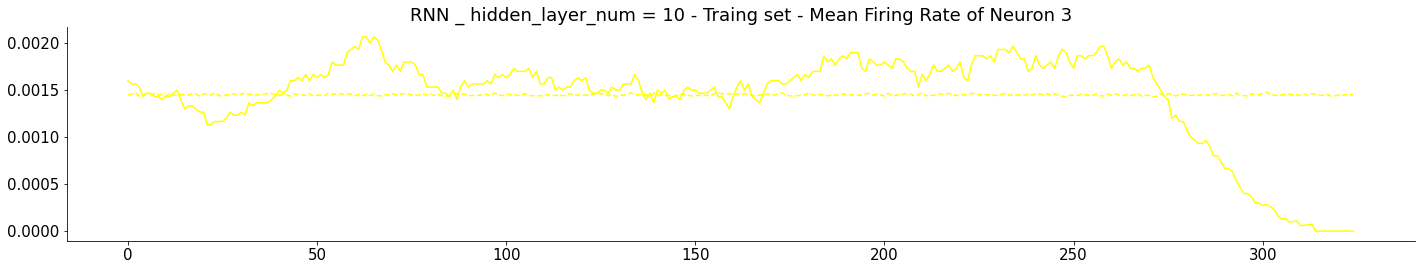

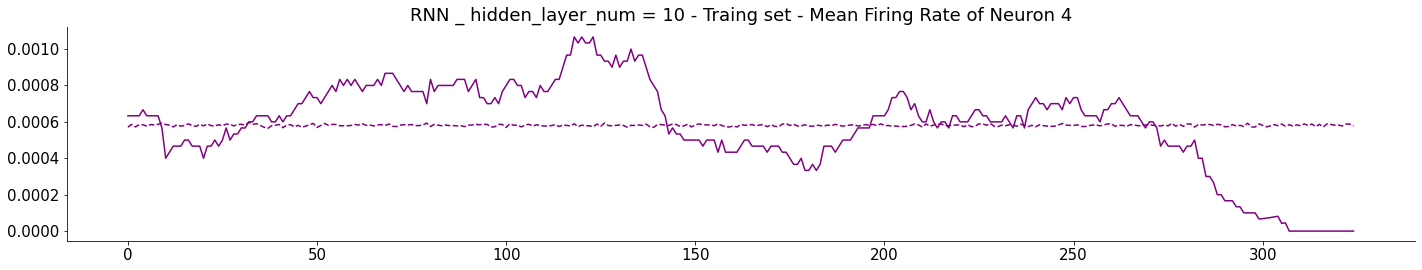

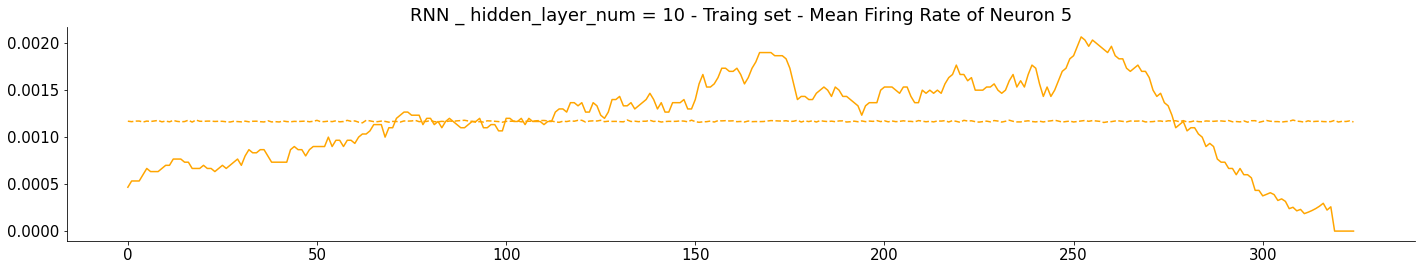

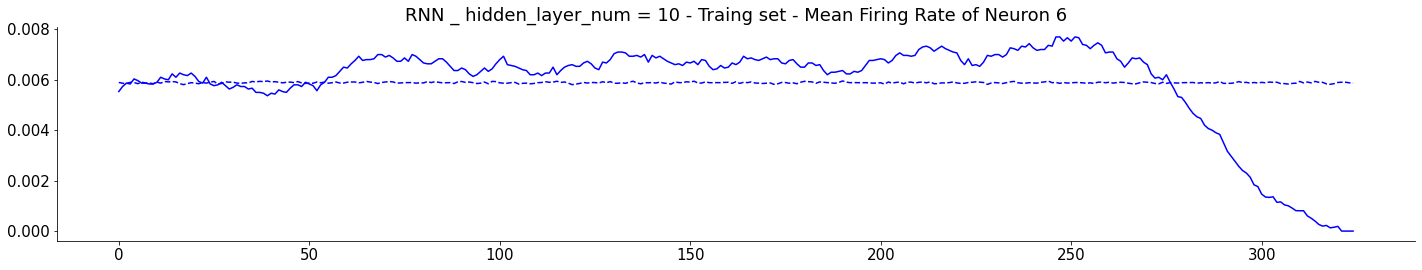

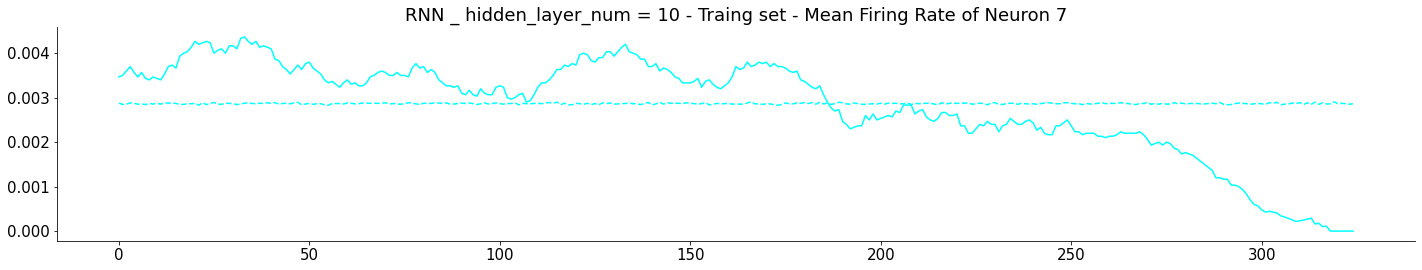

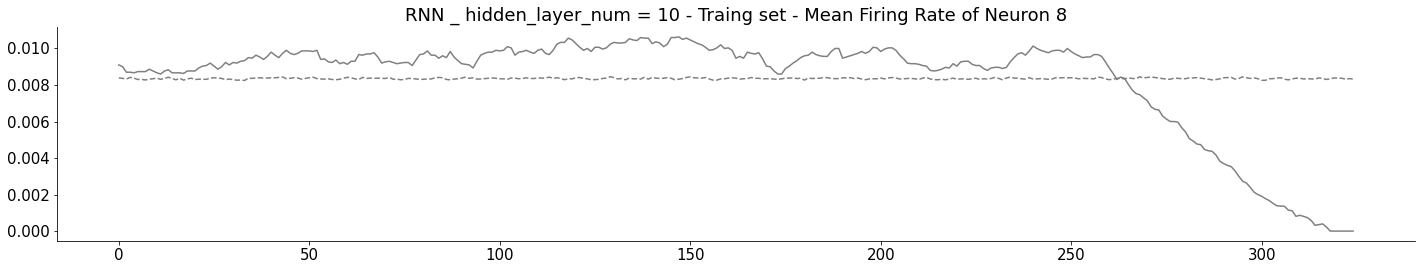

In [ ]:
title_add = f"RNN _ hidden_layer_num = {hidden_layer_num}"
colors = ['r','g','pink','yellow','purple','orange','blue','cyan','gray']
for i in range(9):
  plt.plot(train_pred_mean[i][10:], c=colors[i], alpha=1, linestyle='dashed')
  plt.plot(train_true_mean[i][10:], c=colors[i], alpha=1)
  plt.title(f"{title_add} - Traing set - Mean Firing Rate of Neuron {i}")
  #plt.ylim(0, 0.02)
  plt.show()

##Testing set 

In [ ]:
test_predict, test_y = net(test_input) 

#change to numpy array
test_predict_np = test_predict.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()
    

#calculate mean firing rate across trials
test_pred_mean = []
for i in range(9):
    mean = test_predict_np[:,:,i].mean(axis=1)
    test_pred_mean.append(mean)

test_true_mean = []
for i in range(9):
    mean = test_output_np [:,:,i].mean(axis=1)
    test_true_mean.append(mean)

In [ ]:
len(test_pred_mean[0])

335

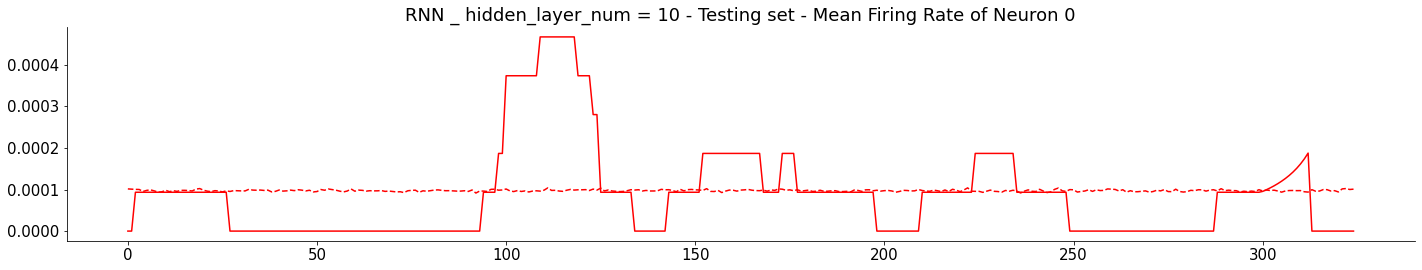

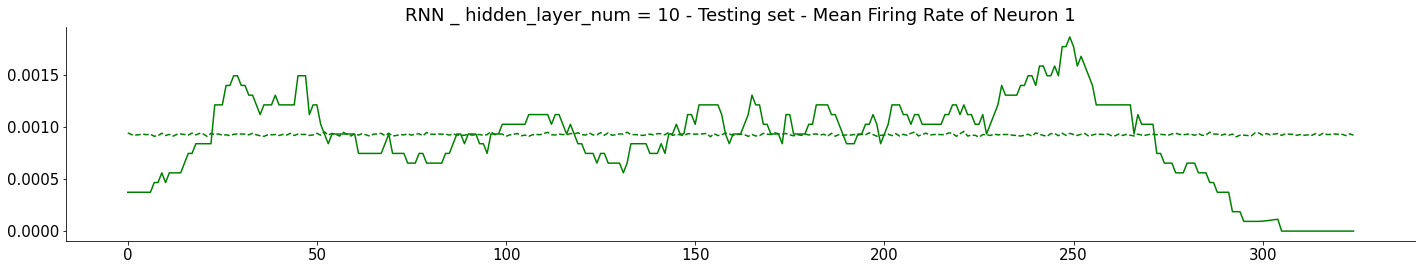

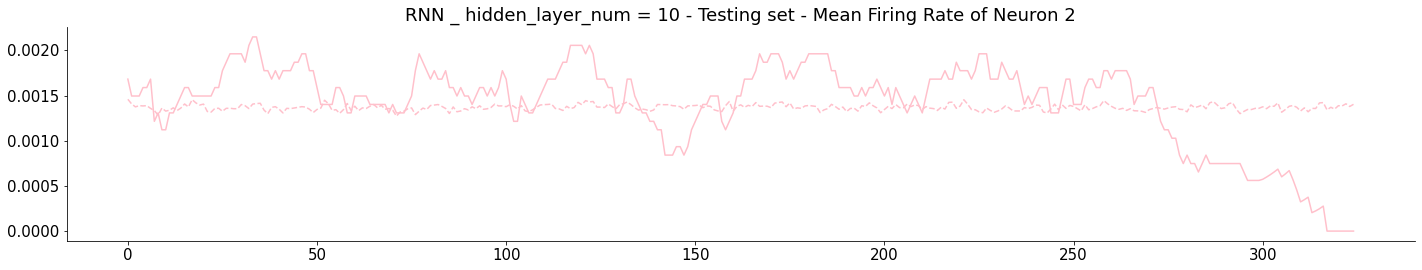

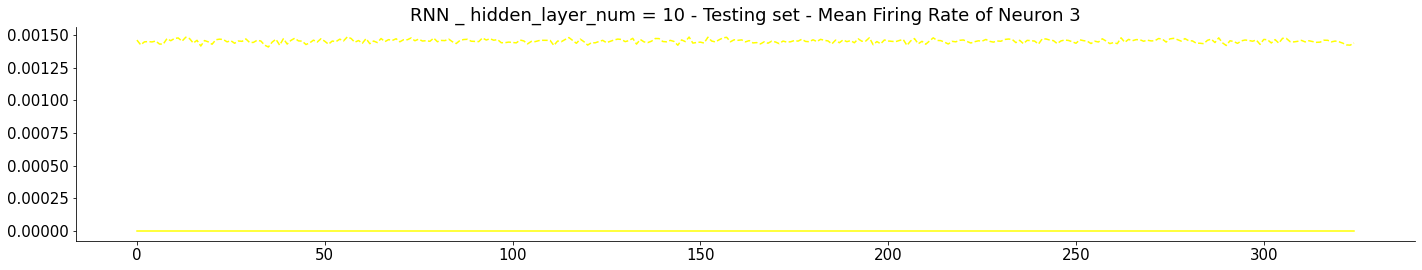

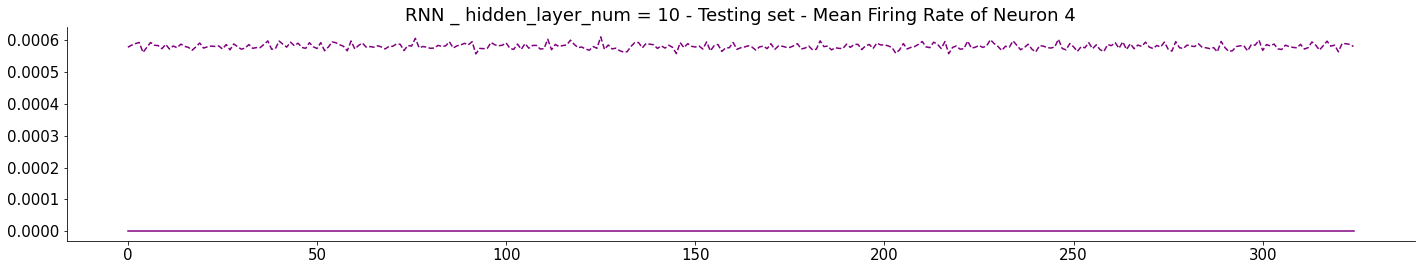

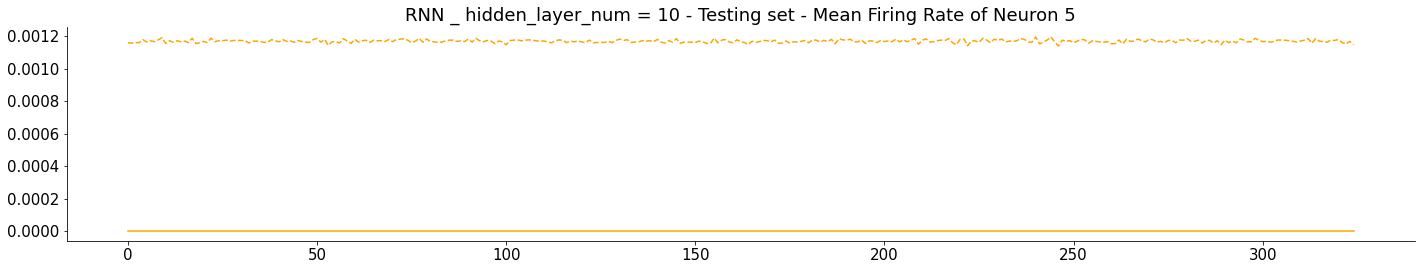

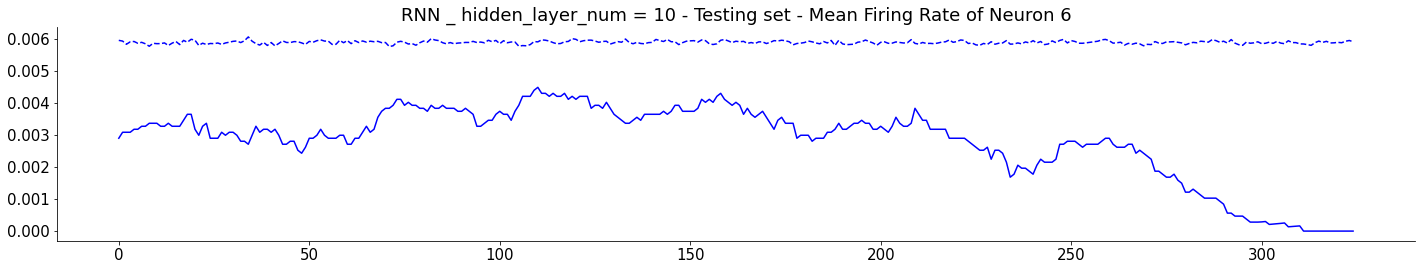

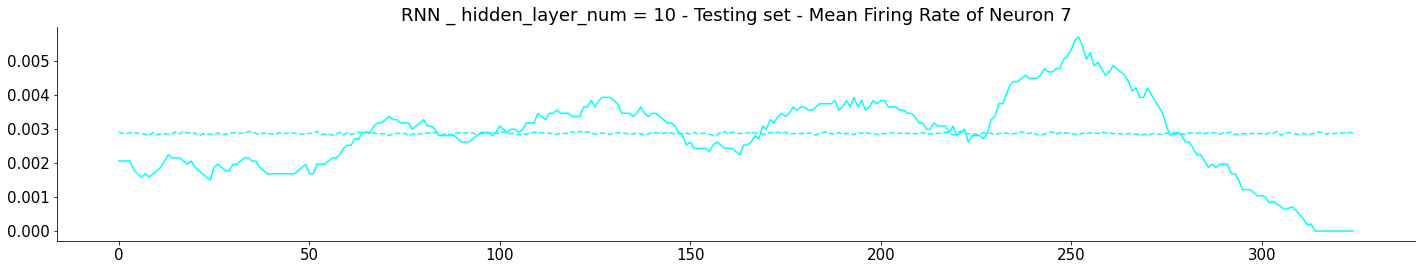

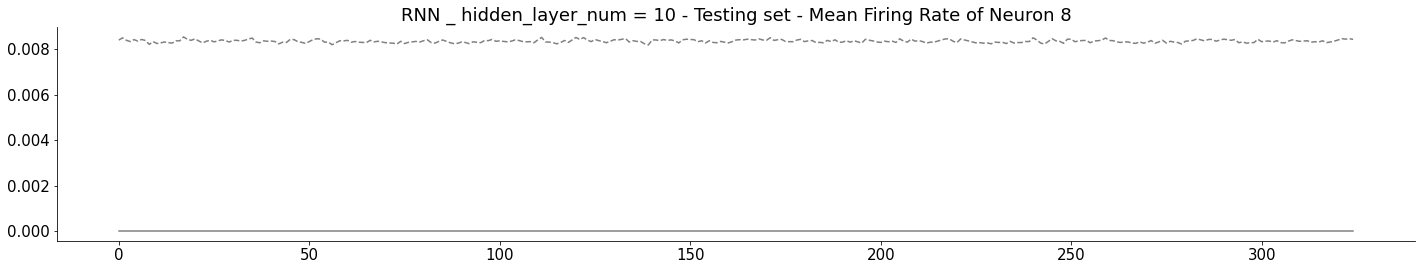

In [ ]:
colors = ['r','g','pink','yellow','purple','orange','blue','cyan','gray']
for i in range(9):
  plt.plot(test_pred_mean[i][10:], c=colors[i], alpha=1, linestyle='dashed')
  plt.plot(test_true_mean[i][10:], c=colors[i], alpha=1)
  plt.title(f"{title_add} - Testing set - Mean Firing Rate of Neuron {i}")
  #plt.ylim(0, 0.02)
  plt.show()

## Testing set

In [ ]:
test_predict, test_y = net(test_input) 

In [ ]:
#change to numpy array
test_predict_np = test_predict.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

In [ ]:
#calculate mean firing rate across trials
test_pred_mean = []
for i in range(9):
    mean = test_predict_np[:,:,i].mean(axis=1)
    test_pred_mean.append(mean)

test_true_mean = []
for i in range(9):
    mean = test_output_np [:,:,i].mean(axis=1)
    test_true_mean.append(mean)


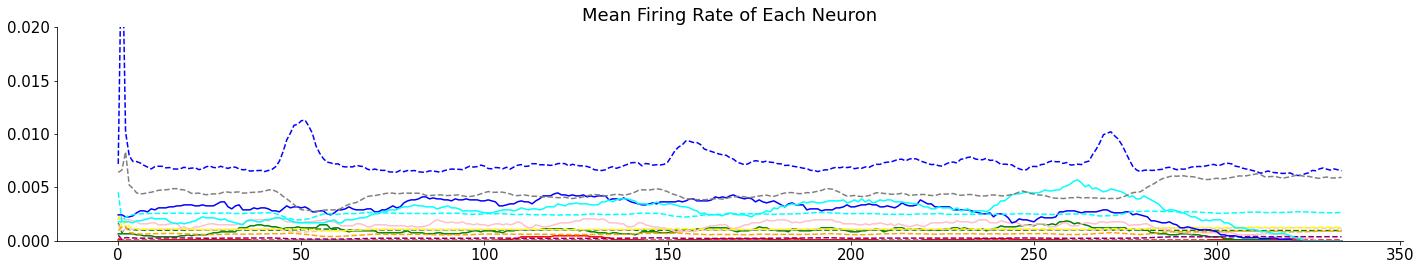

In [ ]:
colors = ['r','g','pink','yellow','purple','orange','blue','cyan','gray']
for i in range(9):
    plt.plot(test_pred_mean[i], c=colors[i], alpha=1, linestyle='dashed')
    plt.plot(test_true_mean[i], c=colors[i], alpha=1)

plt.title('Mean Firing Rate of Each Neuron')
plt.ylim(0, 0.02)

plt.show()

In [ ]:
test = Poisson_loss(test_predict, test_output)
test_np = test.detach().cpu().numpy()
test_np.shape

(335, 107, 9)

## H = 10

In [ ]:
n_hidden = 10
net = Net(n_hidden, NN1, NN2, bidi = False).to(device) #initilization of the model parameters
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

%time
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000 #number of iteration
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(train_input)  #z: predictive output series, y:latent layer

  # our log-likelihood cost
  cost = Poisson_loss(z, train_output).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.58 µs
iteration 0, cost 0.1373
iteration 100, cost 0.0165
iteration 200, cost 0.0164
iteration 300, cost 0.0164
iteration 400, cost 0.0164
iteration 500, cost 0.0164
iteration 600, cost 0.0163
iteration 700, cost 0.0163
iteration 800, cost 0.0163
iteration 900, cost 0.0162


In [ ]:
test_predict, test_y = net(test_input) 

#change to numpy array
test_predict_np = test_predict.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()
    

#calculate mean firing rate across trials
test_pred_mean = []
for i in range(9):
    mean = test_predict_np[:,:,i].mean(axis=1)
    test_pred_mean.append(mean)

test_true_mean = []
for i in range(9):
    mean = test_output_np [:,:,i].mean(axis=1)
    test_true_mean.append(mean)

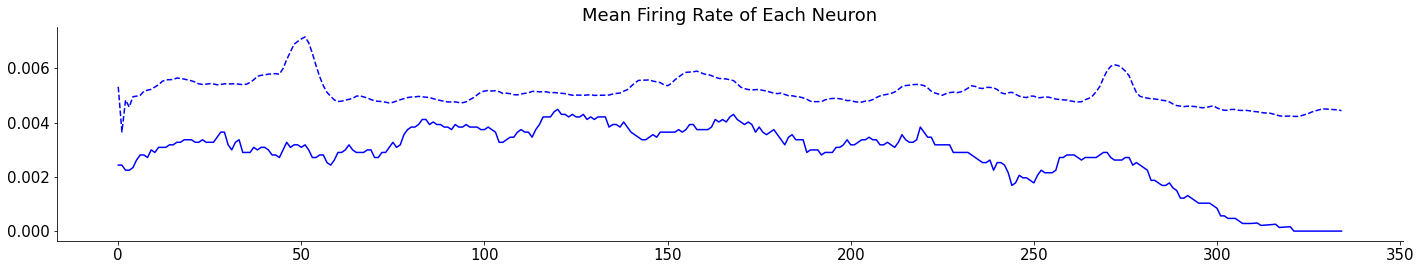

In [ ]:
colors = ['r','g','pink','yellow','purple','orange','blue','cyan','gray']
i = 6
plt.plot(test_pred_mean[i], c=colors[i], alpha=1, linestyle='dashed')
plt.plot(test_true_mean[i], c=colors[i], alpha=1)

plt.title('Mean Firing Rate of Each Neuron')
#plt.ylim(0, 0.02)

plt.show()

In [ ]:
test_np[:,0,0]

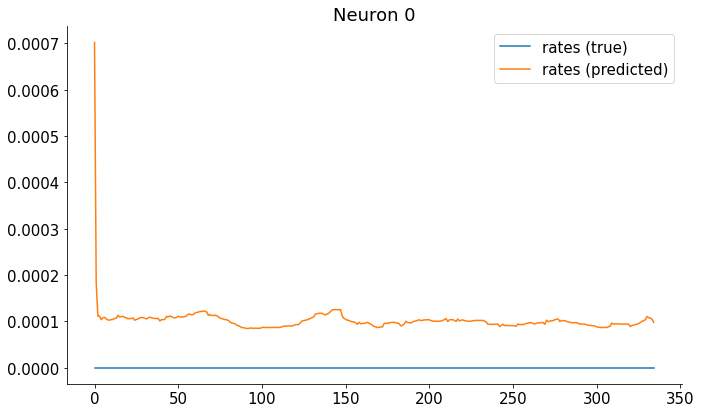

In [ ]:
rpred = z.detach().cpu().numpy()

test_output = test_output.cpu()
test_predict = test_predict.detach().cpu().numpy()

neuron = 0
test_trial = 10
plt.figure(figsize=(10, 6))
plt.plot(test_output[:,test_trial, neuron])
plt.plot(test_predict[:,test_trial, neuron])
#plt.plot(-.5 + training_set[:, test_trial, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {neuron}')
plt.show()

In [ ]:


fig, axes = plt.subplots(3, figsize=(20,20))

for i in range(9):
    for j in range(107):
        axes[0].plot(np.array(test_output_np[:,j,i]), c=colors[i], alpha=0.4)
axes[0].set_title('Each Trial, Each Neuron - Test Output Data')
        

for i in range(9):
    for j in range(107):
        axes[1].plot(test_predict_np[:,j,i], c=colors[i], alpha=0.4, zorder=1)
#     axes[1].plot(test_output_means[i],c='red', linestyle='dashed', linewidth=1, zorder=2)
    
axes[1].set_title('Each Trial, Each Neuron - Test Output Prediction')
axes[1].set_ylim(0,0.02)

for i in range(9):
    for j in range(107):
        axes[2].plot(np.array(test_output_1[:,j,i]), c=colors[i], alpha=0.4)
axes[2].set_title('Mean Firing Rate of Each Neuron')

        

plt.show()


## View firing rates for all neurons in one trial

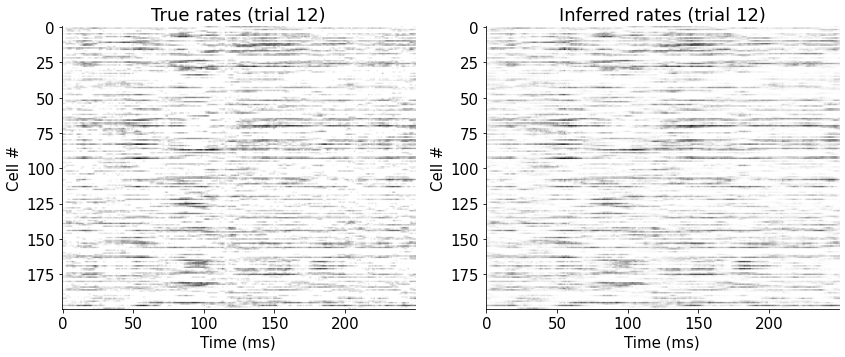

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, 12, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

---
# Visualize the latent dynamics

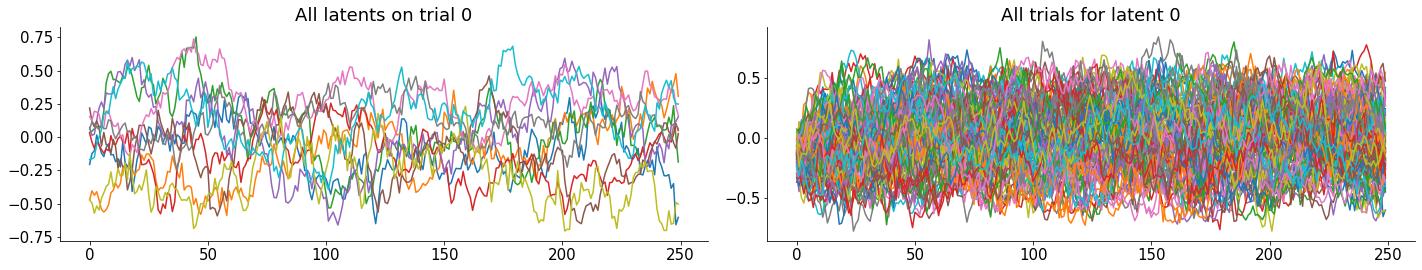

In [ ]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

Not much to see for the latents. This is not surprising, since we generated them with random data, so they look just like a random walk process. 

Now apply this model on real data and see if you can interpret the latents. 

